In [13]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.optimizers import Adam
from sklearn.metrics import r2_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


print(f'tf_version: {tf.__version__}')

tf_version: 2.13.0


## Data Analysis

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

count           mean            std         min  \
longitude           20640.0    -119.569704       2.003532   -124.3500   
latitude            20640.0      35.631861       2.135952     32.5400   
housing_median_age  20640.0      28.639486      12.585558      1.0000   
total_rooms         20640.0    2635.763081    2181.615252      2.0000   
total_bedrooms      20433.0     537.870553     421.385070      1.0000   
population          20640.0    1425.476744    1132.462122      3.0000   
households          20640.0     499.539680     382.329753      1.0000   
median_income       20640.0       3.870671       1.899822      0.4999   
median_house_value  20640.0  206855.816909  115395.615874  14999.0000   

                            25%          50%           75%          max  
longitude             -121.8000    -118.4900    -118.01000    -114.3100  
latitude                33.9300      34.2600      37.71000      41.9500  
housing_median_age      18.0000      29.0000      37.00000      52.0000  
total_rooms           1447.7500    2127.0000    3148.00000   39320.0000  
total_bedrooms         296.0000     435.0000     647.00000    6445.0000  
population             787.0000    1166.0000    1725.00000   35682.0000  
households             280.0000     409.0000     605.00000    6082.0000  
median_income            2.5634       3.5348       4.74325      15.0001  
median_house_value  119600.0000  179700.0000  264725.00000  500001.0000


Missing Values: 



longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

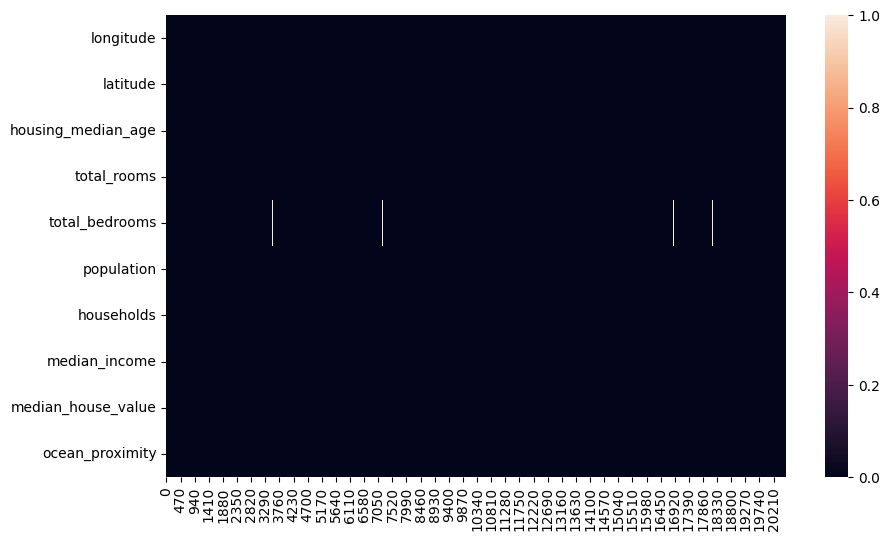

In [79]:
# Loading the dataset
original_df = pd.read_csv('./data/CalifornianHousing.csv', sep=',')
df = original_df.copy()
display(df.head())

display(df.describe().transpose())

print('\nMissing Values: \n')
display(df.isna().sum()) # Detects missing values

#Showing missing data with heatmap before droping 
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose());

df.dropna(thresh = 9,inplace=True) # Removes rows with less than 9 valid features

### Exploratory Data Analysis

/home/matsouto/Code/Py/ML/Supervised Learning/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



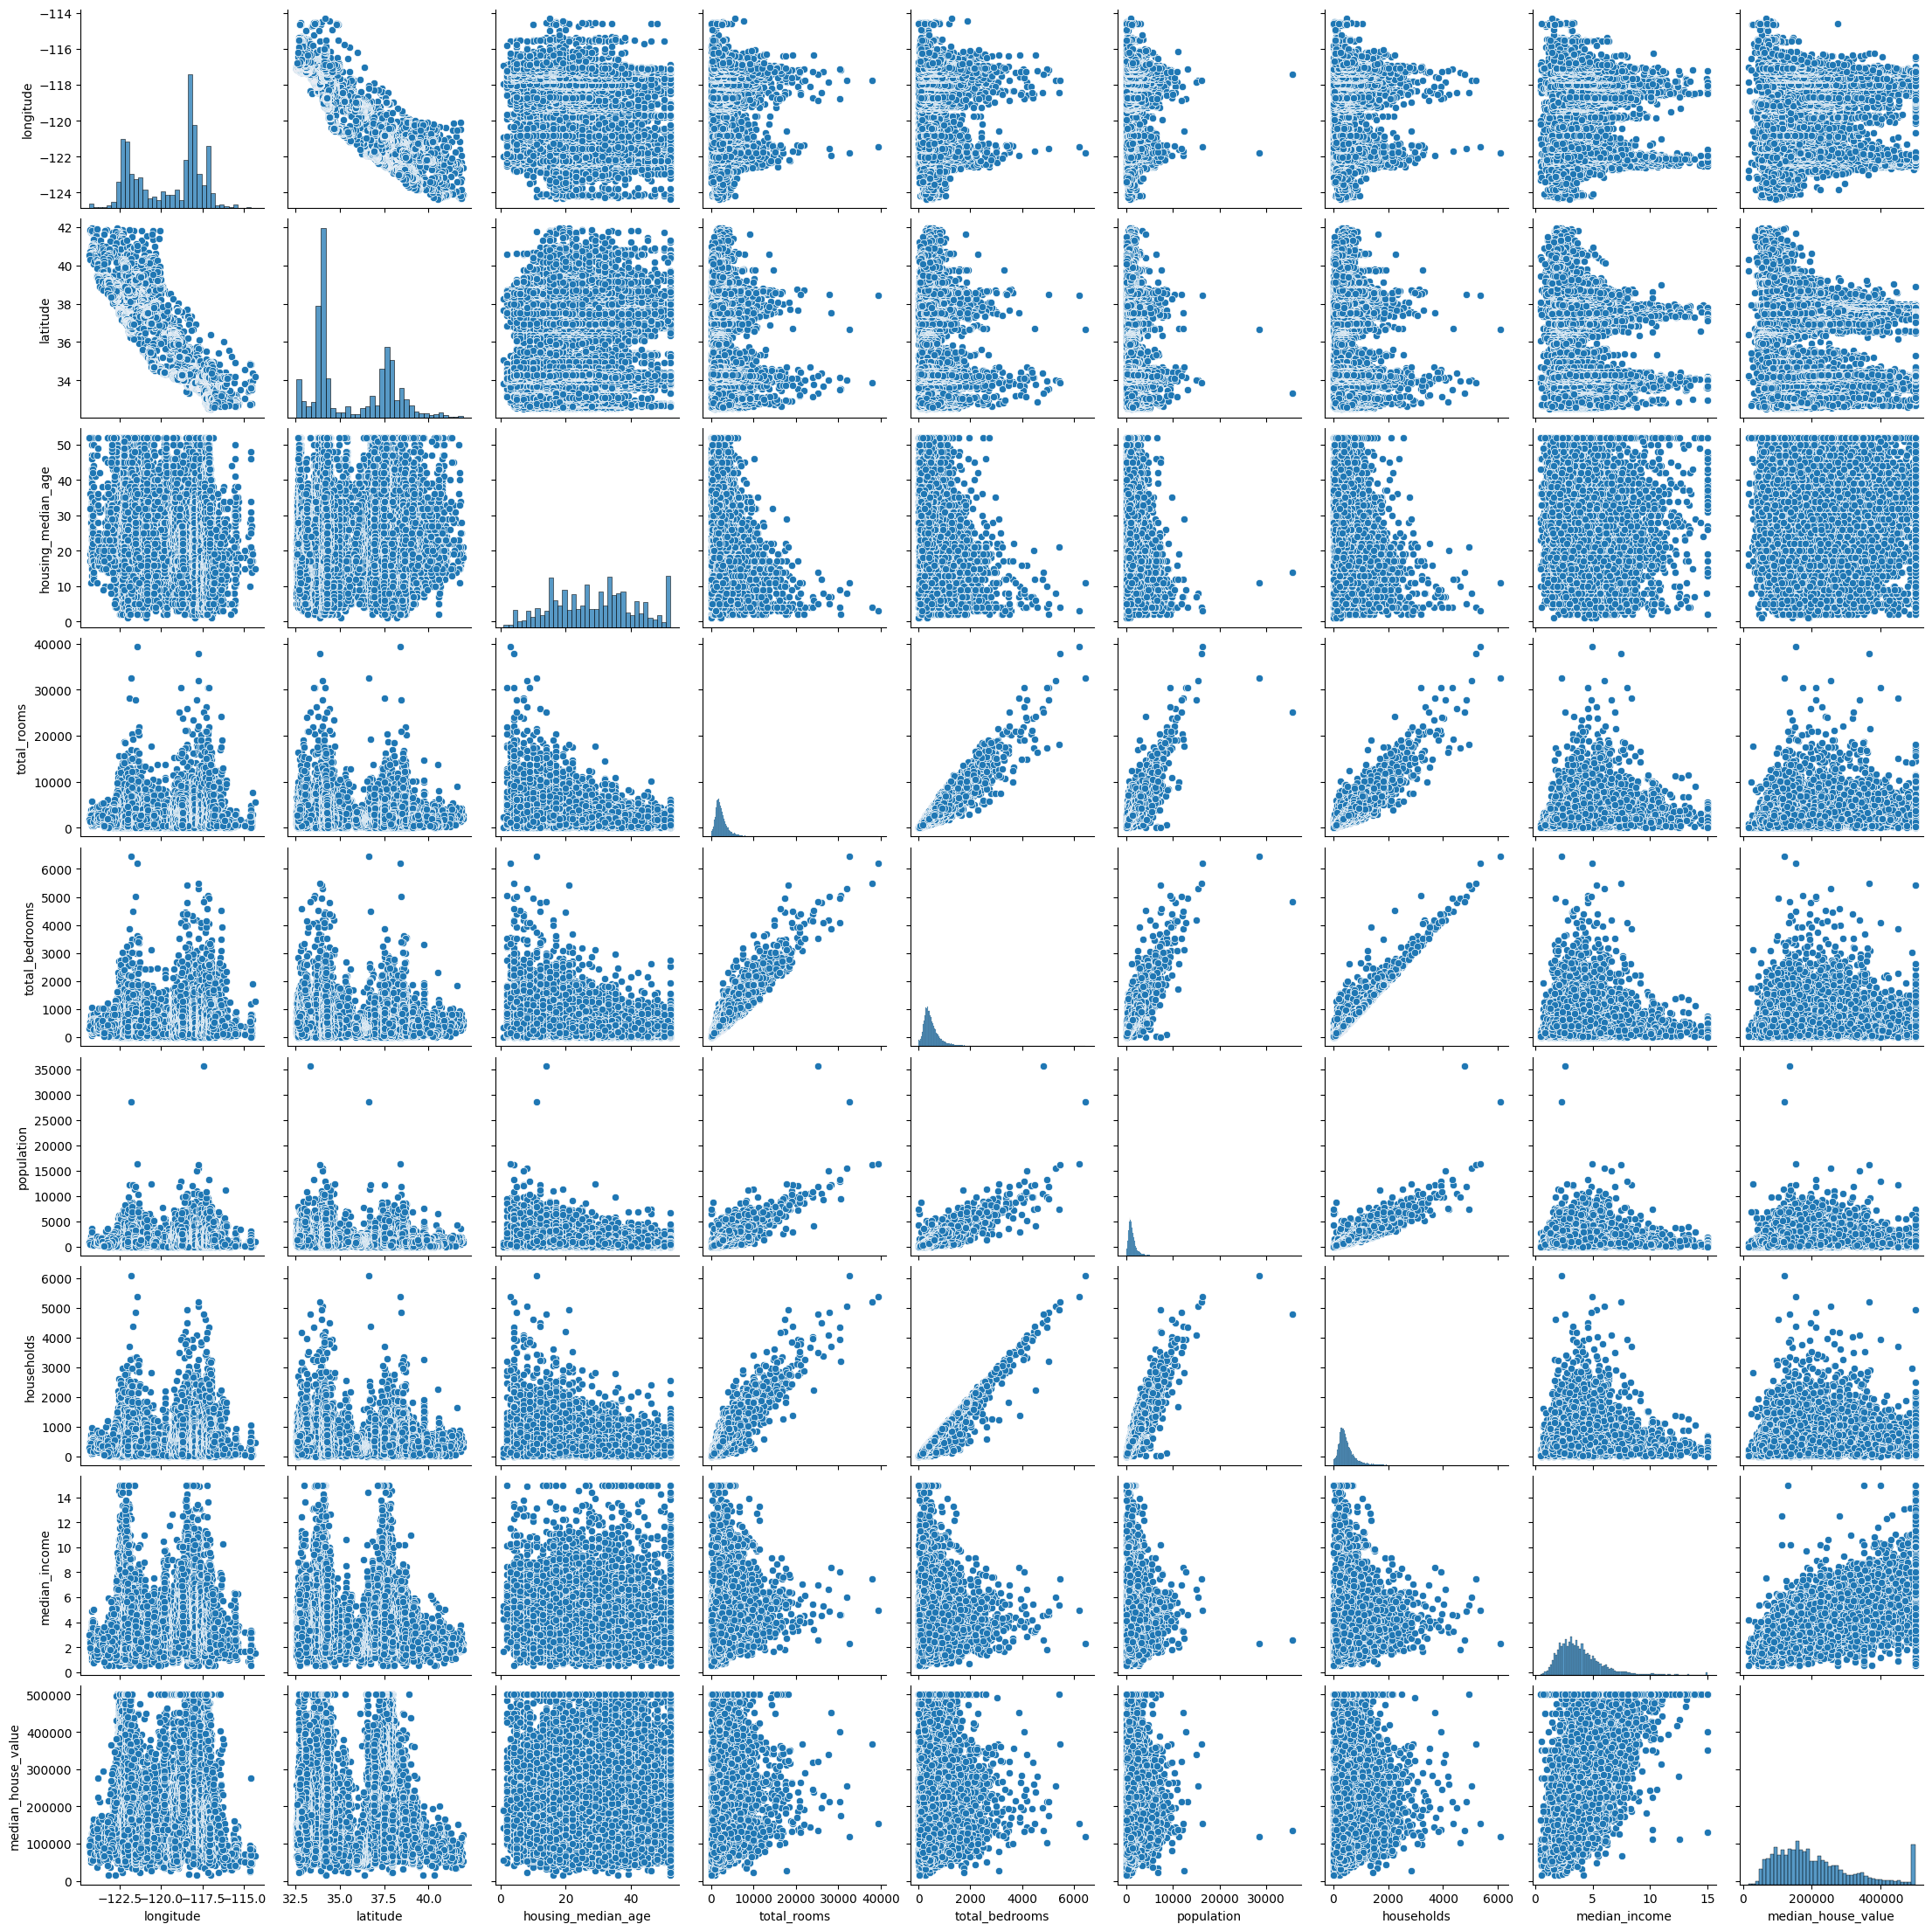

In [32]:
sns.pairplot(data=df)

In [60]:
fig = px.scatter(df, x='housing_median_age', y='median_house_value', size='total_rooms', color='median_income', marginal_x="histogram", labels={col:col.replace('_', ' ') for col in df.columns}) 
fig.show()

fig = px.scatter(df, x="median_income", y="median_house_value", facet_col="ocean_proximity",labels={col:col.replace('_', ' ') for col in df.columns})
fig.show()

In [57]:
fig = px.scatter_matrix(df, 
                        dimensions=df.copy().drop(columns='ocean_proximity').columns, 
                        labels={col:col.replace('_', ' ') for col in df.columns}) # remove underscore
fig.update_traces(marker=dict(size=1, line=dict(width=1, color="darkslategrey")))
fig.update_traces(diagonal_visible=False)
fig.show()

## Data Preprocessing

### Data Manipulation

In [ ]:
ocean_proximity_labels = df['ocean_proximity'].unique()
print('Ocean Proximity Labels: ', ocean_proximity_labels)

# Maps the labels from ocean proximity to integers
df['ocean_proximity'] = df['ocean_proximity'].map({'NEAR BAY' : 1, '<1H OCEAN' : 2, 'INLAND' : 3, 'NEAR OCEAN' : 4, 'ISLAND' : 5}) 
df.head()

In [ ]:
target = 'median_house_value'
features = [i for i in df.columns if i not in target]

x_train_df = df[features]
y_train_df = df[target]
x_train_np = x_train_df.to_numpy()
y_train_np = y_train_df.to_numpy()
print(f'x_train shape: {x_train_np.shape} \t y_train shape: {y_train_np.shape}')

### Feature Scalling
In order to make the training algorithm faster, we normalize the inputs using Keras Normalization layer

In [14]:
print('Before Normalization:')
print(f'Peak-to-peak x_train: {np.ptp(x_train_np, axis=0)}')
display(pd.DataFrame(x_train_np, columns=x_train_df.columns).describe())

# Creating the normalization layer
norm_1 = tf.keras.layers.Normalization(axis=-1) 
# Does the same as passing mean and variance in layer construction
norm_1.adapt(x_train_np) 

# Foward propagating x_train
x_train_norm = norm_1(x_train_np)

print('\nAfter Normalization:')
print(f'Peak-to-peak x_train: {np.ptp(x_train_norm, axis=0)}')
display(pd.DataFrame(x_train_norm, columns=x_train_df.columns).describe())

Before Normalization:
Peak-to-peak x_train: [1.00400e+01 9.41000e+00 5.10000e+01 3.93180e+04 3.56790e+04 6.08100e+03
 1.45002e+01]


longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

         population    households  median_income  
count  20640.000000  20640.000000   20640.000000  
mean    1425.476744    499.539680       3.870671  
std     1132.462122    382.329753       1.899822  
min        3.000000      1.000000       0.499900  
25%      787.000000    280.000000       2.563400  
50%     1166.000000    409.000000       3.534800  
75%     1725.000000    605.000000       4.743250  
max    35682.000000   6082.000000      15.000100


After Normalization:
Peak-to-peak x_train: [ 5.0112433  4.4056435  4.0523643 18.022873  31.50648   15.905506
  7.6325846]


longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        2.064000e+04  2.064000e+04   
mean      -0.000024     -0.000013        6.091687e-07  1.787215e-07   
std        1.000018      1.000026        1.000025e+00  1.000025e+00   
min       -2.386002     -1.447583       -2.196181e+00 -1.207283e+00   
25%       -1.113228     -0.796803       -8.453930e-01 -5.445699e-01   
50%        0.538888     -0.642302        2.864635e-02 -2.332104e-01   
75%        0.778467      0.972945        6.643113e-01  2.348031e-01   
max        2.625242      2.958060        1.856183e+00  1.681559e+01   

         population    households  median_income  
count  2.064000e+04  2.064000e+04   2.064000e+04  
mean   5.899474e-07  4.967978e-07   4.790550e-07  
std    1.000025e+00  1.000024e+00   1.000024e+00  
min   -1.256123e+00 -1.303983e+00  -1.774299e+00  
25%   -5.638088e-01 -5.742290e-01  -6.881181e-01  
50%   -2.291314e-01 -2.368157e-01  -1.767946e-01  
75%    2.644958e-01  2.758432e-01   4.593068e-01  
max    3.025036e+01  1.460152e+01   5.858286e+00

### Tiling

Tile/copy our data to increase the training set size and reduce the number of training epochs.

In [16]:
x_train = np.tile(x_train_norm, (1, 1)) # Repeat 1000 times the rows while keeping the columns.
y_train = np.tile(y_train_np, (1, 1))

print(f'x_train shape before: {x_train_norm.shape}')
print(f'x_train shape after: {x_train.shape}')

x_train shape before: (20640, 7)
x_train shape after: (20640, 7)


## Model Training

### Deep Feed Foward Model Training

![Alt text](images/dff.png)

In [25]:
nn_dff = Sequential([
  InputLayer(input_shape=(x_train.shape[1],)), # This layer can be omitted 
  Dense(units=512, kernel_initializer='normal', activation='relu', name='layer_1'),
  Dense(units=512, kernel_initializer='normal', activation='relu', name='layer_2'),
  Dense(units=256, kernel_initializer='normal', activation='relu', name='layer_3'),
  Dense(units=1, kernel_initializer='normal', activation='linear', name='layer_4')
], name = 'DFF_model')

display(nn_dff.summary()) # The parameter counts correspond to the number of elements in the weight and bias.

Model: "DFF_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 512)               4096      
                                                                 
 layer_2 (Dense)             (None, 512)               262656    
                                                                 
 layer_3 (Dense)             (None, 256)               131328    
                                                                 
 layer_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 398337 (1.52 MB)
Trainable params: 398337 (1.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

In [27]:
# Defines loss function and optimizer
nn_dff.compile( 
    loss = 'mse', # Mean squared error
    optimizer = Adam(learning_rate=0.01),
)

# Runs gradient descent and fits the weights to the data
nn_dff.fit(
    x_train,y_train,            
    epochs=10,
    batch_size=64,
    validation_split = 0.2,
)

Epoch 1/10
258/258 [==============================] - 4s 12ms/step - loss: 3537142528.0000 - val_loss: 4848321536.0000
Epoch 2/10
258/258 [==============================] - 3s 12ms/step - loss: 3545070336.0000 - val_loss: 4762434048.0000
Epoch 3/10
258/258 [==============================] - 3s 12ms/step - loss: 3524618496.0000 - val_loss: 4957874176.0000
Epoch 4/10
258/258 [==============================] - 3s 12ms/step - loss: 3411921408.0000 - val_loss: 4797066752.0000
Epoch 5/10
258/258 [==============================] - 3s 12ms/step - loss: 3334303232.0000 - val_loss: 4752423424.0000
Epoch 6/10
258/258 [==============================] - 3s 12ms/step - loss: 3333467904.0000 - val_loss: 4874754048.0000
Epoch 7/10
258/258 [==============================] - 3s 12ms/step - loss: 3210423552.0000 - val_loss: 4693102080.0000
Epoch 8/10
258/258 [==============================] - 3s 12ms/step - loss: 3175397888.0000 - val_loss: 4777957888.0000
Epoch 9/10
258/258 [============================

In [30]:
p_dff = nn_dff.predict(x_train_norm)
print(nn_dff.get_layer('layer_4').get_weights()[0].shape)
print('Prediction on training set: \n', p_dff[:5,:], '\n')
print('Target values: \n', y_train_np[:5,:], '\n')
print('Model accuracy (delta <= 10000): %f'%(np.mean(np.abs(p_dff - y_train_np) <= 10000)))
print(f'R2 Score: {r2_score(y_train_np, p_dff)}\n')

645/645 [==============================] - 2s 3ms/step
(256, 1)
Prediction on training set: 
 [[396437.88]
 [420844.06]
 [383401.66]
 [309534.72]
 [263788.97]] 

Target values: 
 [[452600.]
 [358500.]
 [352100.]
 [341300.]
 [342200.]] 

Model accuracy (delta <= 10000): 0.210029
R2 Score: 0.7416812055664426



### Conclusion:

The model performed better with the loss set to mean squared error.
